In [135]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [136]:
sp500_tickers = pickle.load(open('data/stock/iterables/sp500_tickers.pkl', 'rb'))
nasdaq_100_tickers = pickle.load(open('data/stock/iterables/nasdaq_100_tickers.pkl', 'rb'))
time_intervals = pickle.load(open('data/stock/iterables/time_intervals.pkl', 'rb'))

In [137]:
def check_performance(df):
    temp = []
    for arr in df:
        temp.append(sum(arr))
    count, total = 0, 0
    for elem in temp:
        if elem >= 0:
            count += 1
        total += elem
    return count, total

In [138]:
def pnl_calc(data):
    pnl_period = []
    for idx, row in data.iterrows():
        pred_diff = round(row['open'] - row['pred'], 2)
        actual_diff = round(row['open'] - row['close'], 2)
        # if trading in same direction 
        if ((pred_diff >= 0 and actual_diff >= 0) or 
            (pred_diff <= 0 and actual_diff <= 0)):
            pnl_period.append(abs(actual_diff))
        else: # assumes trade at open
            pnl_period.append(-1*abs(actual_diff))
    return np.array(pnl_period)

In [139]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='mean')

In [140]:
def get_pnl_for_time(bartime):
    pnl_data = []
    for ticker in sp500_tickers:
        data = pd.read_csv('stock/data/predicted/{t}/{t}_{b}_pred.csv'.format(t=ticker,b=bartime))
        data = pnl_calc(data)
        pnl_data.append(data)
    for idx, row in enumerate(pnl_data):
        pnl_data[idx] = padarray(row, 252)
    pnl_data = np.array(pnl_data)
    return pnl_data

In [141]:
def plot_pnl(pnl_data, plt_col, plt_rows, gen_rand=False, with_title=False):
    fig, axs = plt.subplots(plt_rows, plt_col)
    plt.tight_layout(pad=.5)
    ymin, ymax = -10, 10
    plotted_idx = []
    for i in range(0,plt_rows):
        for j in range(0,plt_col):
            idx = (i * plt_col) + j
            if gen_rand:
                idx = random.randint(0,502) # random index value
                while idx in plotted_idx:
                    idx = random.randint(0,502) # generated until get a new ticker
                plotted_idx.append(idx)
            # reached end
            if idx >= len(pnl_data):
                break
            color = 'r' if sum(pnl_data[idx]) < 0 else 'b'
            axs[i,j].plot(pnl_data[idx], linewidth=0.5, color=color)
            axs[i,j].set_ylim([ymin, ymax])
            if with_title:
                axs[i,j].set_title(sp500_tickers[idx], fontsize=10)
    for ax in axs.flat:
        ax.label_outer()

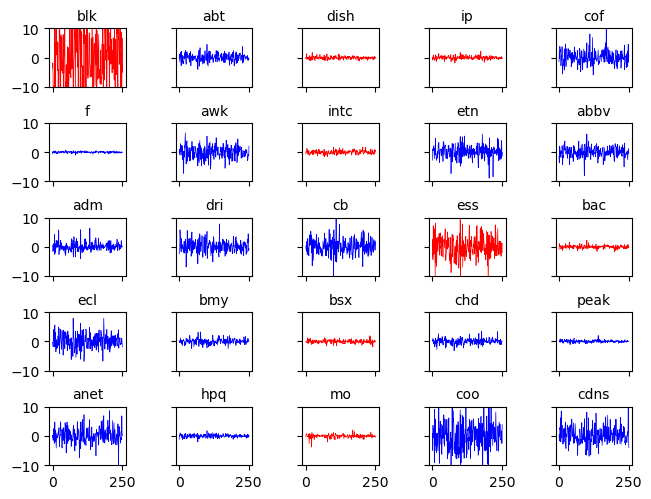

In [142]:
# generate 25 random samples
# set plt_col=25, plt_row=26 for max
pnl_day_data = get_pnl_for_time('1_day')
plot_pnl(pnl_day_data, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)

In [166]:
day_1_bench = check_performance(pnl_day_data)
day_1_bench

(279, 2454.315662013249)

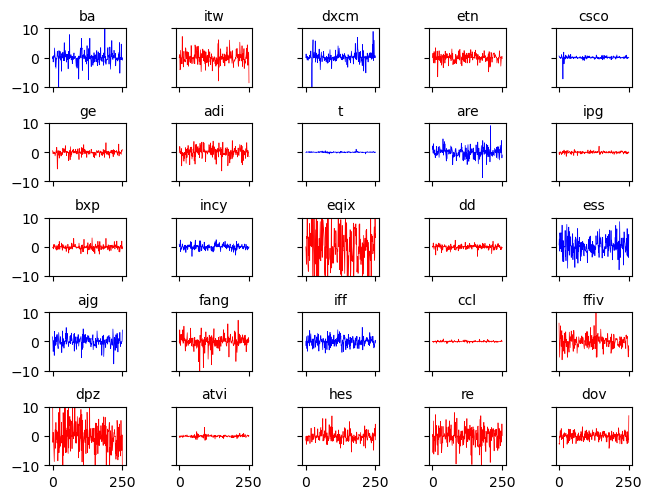

In [144]:
# generate 25 random samples
# set plt_col=25, plt_row=26 for max
pnl_4h_data = get_pnl_for_time('4_hour')
plot_pnl(pnl_4h_data, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)

In [167]:
hour_4_bench = check_performance(pnl_4h_data)
hour_4_bench

(246, 316.0500000000015)

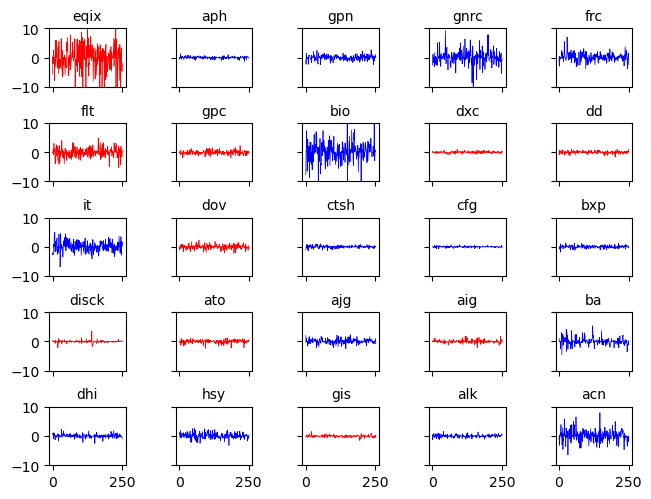

In [146]:
# generate 25 random samples
# set plt_col=25, plt_row=26 for max
pnl_1h_data = get_pnl_for_time('1_hour')
plot_pnl(pnl_1h_data, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)

In [168]:
hour_1_bench = check_performance(pnl_1h_data)
hour_1_bench

(247, -290.26000000000033)

In [148]:
def pnl_calc_sd(data, sd, modif):
    pnl_period = []
    for idx, row in data.iterrows():
        pred_diff = round(row['pred'] - row['open'], 2)
        actual_diff = round(row['close'] - row['open'], 2)
        low_diff = abs(round(row['low'] - row['open'], 2))
        high_diff = abs(round(row['high'] - row['open'], 2))
        # throw out trades that go beyond 1 SD in opposite direction
        if ((pred_diff > 0 and low_diff <= modif*sd and actual_diff > 0) or 
            (pred_diff < 0 and high_diff <= modif*sd and actual_diff < 0)):
            pnl_period.append(abs(actual_diff))
        elif (pred_diff > 0 and low_diff > modif*sd) or (pred_diff < 0 and high_diff > modif*sd):
            pnl_period.append(-1*modif*sd)
        else: # take the loss less than sd
            pnl_period.append(-1*abs(actual_diff))
    return np.array(pnl_period)

In [149]:
def get_pnl_for_time_sd(bartime, modif):
    pnl_data = []
    df_summary = pd.read_csv('stock/data/pnl/gaussian/pnl_summary.csv', header=[0], index_col=[0])
    for ticker in sp500_tickers:
        data = pd.read_csv('stock/data/predicted/{t}/{t}_{b}_pred.csv'.format(t=ticker,b=bartime))
        label = bartime + '_std'
        sd = df_summary.at[ticker,label]
        data = pnl_calc_sd(data, sd, modif)
        pnl_data.append(data)
    for idx, row in enumerate(pnl_data):
        pnl_data[idx] = padarray(row, 252)
    pnl_data = np.array(pnl_data)
    return pnl_data

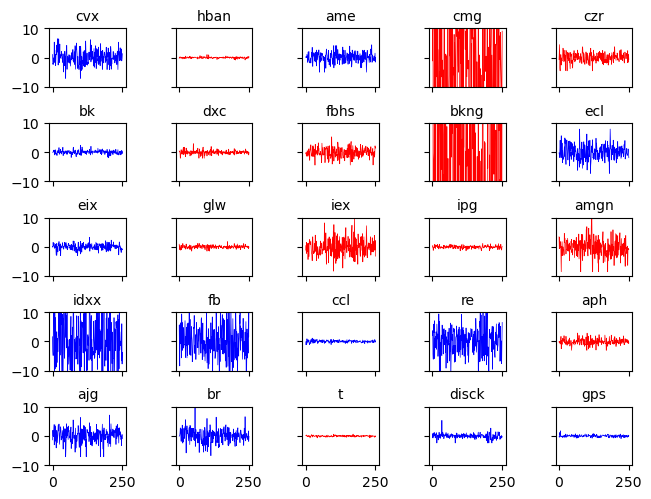

In [150]:
pnl_day_data_sd = get_pnl_for_time_sd('1_day', 3)
plot_pnl(pnl_day_data_sd, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)


In [151]:
#compare to bench
profitable_tickers, total_pnl = check_performance(pnl_day_data_sd)
diff_ticker_count = profitable_tickers - day_1_bench[0]
diff_total_pnl = total_pnl - day_1_bench[1]
print(diff_ticker_count)
print(diff_total_pnl)

-3
-512.8462686307953


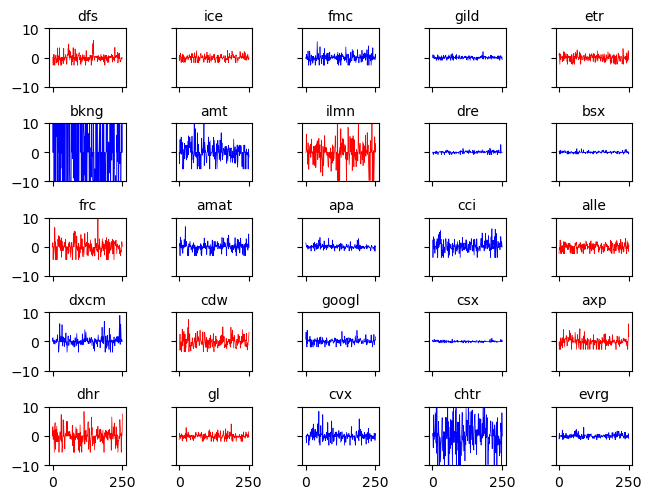

In [162]:
pnl_4h_data_sd = get_pnl_for_time_sd('4_hour', 2)
plot_pnl(pnl_4h_data_sd, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)

In [163]:
#compare to bench
profitable_tickers, total_pnl = check_performance(pnl_4h_data_sd)
diff_ticker_count = profitable_tickers - hour_4_bench[0]
diff_total_pnl = total_pnl - hour_4_bench[1]
print(diff_ticker_count)
print(diff_total_pnl)

-1
289.3799999999986


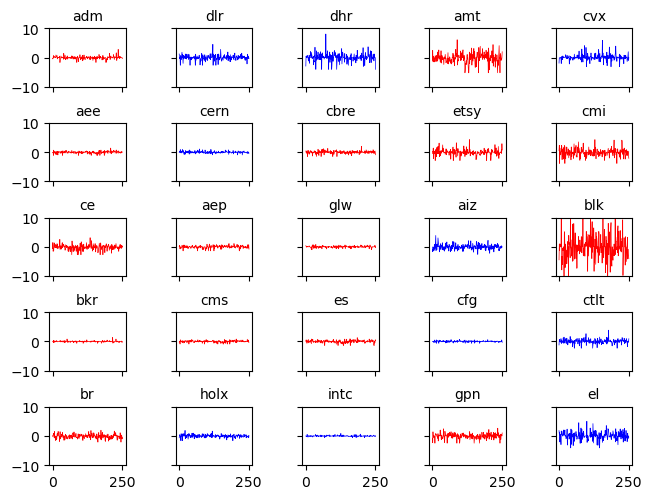

In [154]:
pnl_1h_data_sd = get_pnl_for_time_sd('1_hour', 3)
plot_pnl(pnl_1h_data_sd, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)

In [155]:
#compare to bench
profitable_tickers, total_pnl = check_performance(pnl_1h_data_sd)
diff_ticker_count = profitable_tickers - hour_1_bench[0]
diff_total_pnl = total_pnl - hour_1_bench[1]
print(diff_ticker_count)
print(diff_total_pnl)

-2
-276.36


Incomplete still wroking on

In [156]:
# visualize the high low differences

In [171]:
def high_low_diff(data):
    high_diff = data['high'].sub(data['open'], axis=0)
    low_diff = data['low'].sub(data['open'], axis=0)
    print(low_diff)
    print(high_diff)

In [ ]:
def get_high_low_for_time(bartime):
    high_diff, low_diff = [], []
    for ticker in sp500_tickers:
        data = pd.read_csv('stock/data/predicted/{t}/{t}_{b}_pred.csv'.format(t=ticker,b=bartime))
        data = pnl_calc(data)
        pnl_data.append(data)
    for idx, row in enumerate(pnl_data):
        pnl_data[idx] = padarray(row, 252)
    pnl_data = np.array(pnl_data)
    return pnl_data

In [ ]:
pnl_day_data = get_pnl_for_time('1_day')
high_low_diff(pnl_day_data)